***This notebook use additional modules for models output and training process visualization, please install them if they are not exist in your environment***

In [ ]:
!pip install tqdm
!pip install matplotlib 
!pip install pytorch_msssim

In [1]:
# set up an absolute path to the project 
# not needed in case of `pip install`
%run -i ../tools/setup_env.py

## Usage examples of `torchcnnbuilder.models`

This submodule contains CNN-model templates that were assembled using `torchcnnbuilder.builder`. So far, there is only a model template for predicting n-dimensional time series *(two-dimensional convolutional layers are used)*

### Model `ForecasterBase`

Initialization params:
* **input_size** (Tuple[int, int]): input size of the input tensor of the one time point
* **n_layers** (int): number of the convolution layers in the encoder part
* **in_time_points** (int): number of time points (channels) in the first input tensor (prehistory size)
* **out_time_points** number of time points (channels) in the last output tensor (forecasting size)
* **conv_dim**: the dimension of the convolutional operation 2 or 3. Default: 2
* **n_transpose_layers** (Optional[int]): number of the transpose convolution layers in the encoder part. Default: None (same as n_layers)
* **convolve_params** (Dict[str, int]): parameters of convolutional layers (by default same as in torch). Default: None
* **transpose_convolve_params** (Dict[str, int]): parameters of transpose convolutional layers (by default same as in torch). Default: None
* **activation_function** (nn.Module): activation function. Default: nn.ReLU(inplace=True)
* **finish_activation_function** (Union[str, Optional[nn.Module]]): last activation function, can be same as activation_function (str `'same'`). Default: None
* **normalization** (str): choice of normalization between str `'dropout'` and `'batchnorm'`. Default: None

Other attributes:
* **convolve** (nn.Sequential): convolutional sequence - encoder part
* **transpose** (nn.Sequential): transpose convolutional sequence - decoder part
* **conv_channels** (List[int]): history list of output channels after each convolutional layer
* **transpose_conv_channels** (List[int]): history list of output channels after each transposed convolutional layer
* **conv_layers** (List[tuple]): history list of output tensor sizes after each convolutional layer
* **transpose_conv_layers** (List[tuple]): history list of output tensor sizes after each transposed convolutional layer

This is the template class of the time series prediction CNN-architecture. The source of the original [article code](https://github.com/ITMO-NSS-team/ice-concentration-prediction-paper?ysclid=lrhxbvsk8s328492826). Below is a diagram of the original architecture of the model (2D version)

<img src="../tools/media/ForecasterBase.png" alt="forecaster model" style="width:70%; display: block; margin-left: auto; margin-right: auto;">

In [2]:
from torchcnnbuilder.models import ForecasterBase

In [3]:
import torch.nn as nn

# example of initialization
model = ForecasterBase(input_size=[65, 65],
                       in_time_points=120,
                       out_time_points=40,
                       n_layers=5,
                       normalization='batchnorm',
                       finish_activation_function=nn.ReLU(inplace=True))

Let's train the model on the synthetic data that was demonstrated in the `prerocess_examples.ipynb` file. First, we will generate the necessary data and create datasets for the train and test parts. We will predict 40 frames of the square movement based on the previous 120 frames and will use batch normalization. A frame-by-frame animation of the train part is attached below:

<img src="../tools/media/train.gif" alt="animation" style="width:40%; display: block; margin-left: auto; margin-right: auto;">

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# using ssim as loss and score metric (firstly you need to pip install it)
from pytorch_msssim import ssim

# time-series preprocessing
from torchcnnbuilder.preprocess import multi_output_tensor, single_output_tensor

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f'Calculating on device: {device}')

Calculating on device: cuda


In [6]:
%%capture
from examples.tools.generating_time_series import synthetic_time_series

In [7]:
%%capture
# generating data
_, data = synthetic_time_series(num_frames=360,
                                matrix_size=65,
                                square_size=13)

In [8]:
# train consists of three cycles of a full circle of the square so that the model can see the trend
train = data + data + data
test = data[10:170]

In [9]:
print(f'Train dataset len: {len(train)}, One matrix shape: {train[0].shape}')
print(f'Test dataset len: {len(test)}, One matrix shape: {test[0].shape}')

Train dataset len: 1080, One matrix shape: (65, 65)
Test dataset len: 160, One matrix shape: (65, 65)


In [10]:
train_dataset = multi_output_tensor(data=train,
                                    pre_history_len=120,
                                    forecast_len=40)

test_dataset = single_output_tensor(data=test, 
                                   forecast_len=40)

C:\Users\Julia\Documents\NSS_lab\TorchCNNBuilder\torchcnnbuilder\preprocess\_dynamic_window.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  tensors = torch.Tensor(data)


In [11]:
# checking train_dataset
for i, batch in enumerate(train_dataset):
    print(f'batch number: {i}',
          f'X shape: {batch[0].shape}\nY shape: {batch[1].shape}',
          sep='\n',
          end='\n\n')
    break
print(f'Dataset len (number of batches/X-windows): {len(train_dataset)}')

batch number: 0
X shape: torch.Size([120, 65, 65])
Y shape: torch.Size([40, 65, 65])

Dataset len (number of batches/X-windows): 920


In [12]:
# checking test_dataset
for i, batch in enumerate(test_dataset):
    print(f'X shape: {batch[0].shape}\nY shape: {batch[1].shape}',
          end='\n\n')

print(f'Dataset len (number of batches/X-windows): {len(test_dataset)}')

X shape: torch.Size([120, 65, 65])
Y shape: torch.Size([40, 65, 65])

Dataset len (number of batches/X-windows): 1


In [13]:
epochs = 1000
batch_size = 50

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [14]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

In [15]:
losses = []

for epoch in tqdm(range(epochs)):
    loss = 0
    
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)
        
        optimizer.zero_grad()
        outputs = model(train_features)
    
        train_loss = criterion(outputs, test_features)
        
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(dataloader)
    
    losses.append(loss)
    
    if epoch % 100 == 0 or epoch - 1 == epochs:
        tqdm.write("epoch : {}/{}, recon loss = {:.8f}".format(epoch+1, epochs, loss))

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch : 1/1000, recon loss = 0.15146854
epoch : 101/1000, recon loss = 0.00982173
epoch : 201/1000, recon loss = 0.00737619
epoch : 301/1000, recon loss = 0.00561074
epoch : 401/1000, recon loss = 0.00420295
epoch : 501/1000, recon loss = 0.00404137
epoch : 601/1000, recon loss = 0.00325881
epoch : 701/1000, recon loss = 0.00295841
epoch : 801/1000, recon loss = 0.00326116
epoch : 901/1000, recon loss = 0.00241776


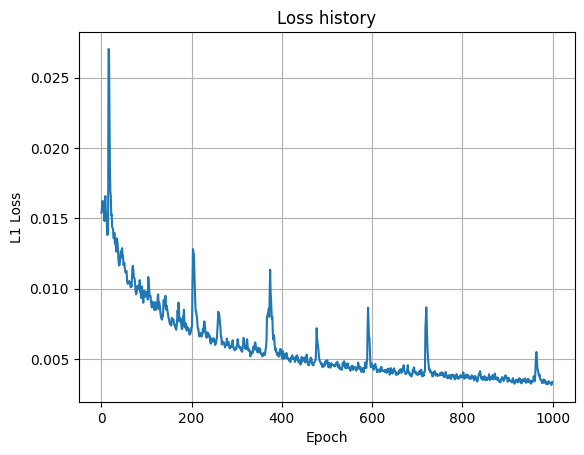

In [18]:
plt.plot(list(range(epochs)), losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Loss history')
plt.show()

In [19]:
# checking the result score
with torch.no_grad():
    model.eval()
    for X, Y in test_dataset:
        X = X[None, :].to(device)
        Y = Y[None, :].to(device)
            
        outputs = model(X)
        
        l1_val = criterion(outputs, Y)
        ssim_val = ssim(outputs, Y, data_range=1, size_average=False)
        
        print(f'L1 score: {l1_val}')
        print(f'SSIM score: {ssim_val[0]}')

L1 score: 0.007198760751634836
SSIM score: 0.9466716647148132


The L1 score tends to 0, and the SSIM score should tend to 1, which means complete similarity with the original image *(in our case, the forecast of the time series)*

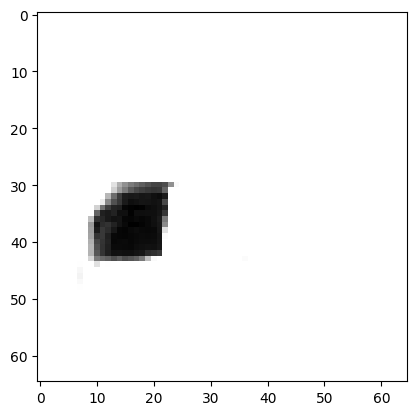

In [20]:
plt.imshow((1-outputs[0].detach().cpu().numpy()[39]), cmap='gray')

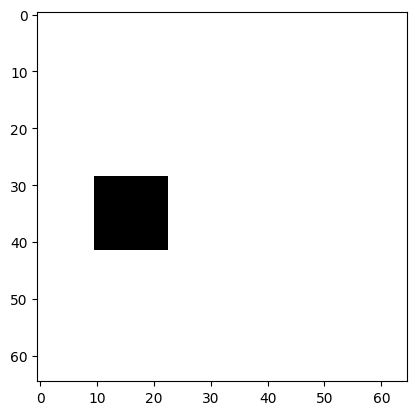

In [21]:
plt.imshow(1 - Y[0].cpu()[39], cmap='gray')

In [23]:
# saving results as a gif-files
from examples.tools.generating_time_series import save_gif

In [27]:
%%capture
save_gif(matrices=outputs[0].detach().cpu().numpy(),
         name='predict')

save_gif(matrices=test[-40:],
         name='test')

save_gif(matrices=train,
         name='train')

In [ ]:
# saving models weights
torch.save(model.state_dict(), "model.pth")

The final result is below (test data and predict for next 40 frames by 120 previous frames)

<table>
  <tr>
    <td align="center">
        <b>Test<b>
      <img src="../tools/media/test.gif">
    </td>
    <td align="center">
        <b>Predict<b>
      <img src="../tools/media/predict.gif">
    </td>
  </tr>
</table>

Also, you can do the same with 3d or 1d convolution version of the Forecaster model:

> Note: if you use 3d convolutions, channels number will be count with using param `channel_growth_rate='power'` in order to make model less heavy. Also, your input_size param should be [H, W]. ForecasterBase3d works only with 2d tensors, which create a 3d tensor with a time period of `in_time_points`.

In [18]:
forecaster3d = ForecasterBase(input_size=[65, 65],
                              in_time_points=10,
                              out_time_points=5,
                              n_layers=3,
                              normalization='dropout',
                              conv_dim=3,
                              finish_activation_function=nn.ReLU(inplace=True))
forecaster3d

ForecasterBase(
  (encoder): Sequential(
    (conv 1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (conv 2): Sequential(
      (0): Conv3d(4, 9, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (conv 3): Sequential(
      (0): Conv3d(9, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
  )
  (decoder): Sequential(
    (deconv 1): Sequential(
      (0): ConvTranspose3d(16, 9, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (deconv 2): Sequential(
      (0): ConvTranspose3d(9, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): Dropout3d(p=0.5, inplace=False)
      (2): ReLU(inplace=True)
    )
    (deconv 3): Sequential(
      (0): ConvTranspose3d(4